## Solving inverse problems with PINN 
- Datasets in the lesson are available through: [https://www.kaggle.com/datasets/yhzang32/2025-course-dl4pde](https://www.kaggle.com/datasets/yhzang32/2025-course-dl4pde)

## (1) How to use the free GPU resource 

### (1.1) [Google Colab](https://colab.research.google.com/)
- **Step 1:** Sign in to your Google Account and open your Google Colab
- **Step 2:** Create a New Notebook
  - Click on “**File**” > “**New notebook**”
  - A new Jupyter notebook will open in your browser.
- **Step 3:** Enable GPU
  - Go to “**Runtime**” > “**Change runtime type**”.
  - Under “**Hardware accelerator**”, select “**GPU**”(or specific GPU device).
  - Click “**Save**”.
- **Step 4:** Check GPU Availability in the notebook
  - In the first code cell, run:
    ```python
    import torch
    torch.cuda.is_available()
    ```

**Note:** One of the reasons Colab can provide free resources is that **it uses dynamic quotas**, which change over time to meet user demand. However, resource availability is not guaranteed or unlimited (**each session lasts up to 12 hours** and may be automatically disconnected).

### (1.2) [Kaggle Notebook](https://www.kaggle.com/code) (30h/week for free use)
- **Step 1:** Create or Open a Kaggle Notebook:
  - Go to Kaggle.
  - Click on “**Code**” > “**New Notebook**” or open an existing one.
- **Step 2:** Enable GPU:
  - In the top-right corner of the notebook editor, click on the “**Settings**” icon.
  - Under “**Accelerator**”, select GPU from the dropdown menu.
- **Step 3:** Verify GPU Availability:
    ```python
    import torch
    print("GPU Available:", torch.cuda.is_available())
    print("GPU Name:", torch.cuda.get_device_name(0))
    ```

## (2) PDE-based Inverse problem

### (2.1) Recovering the permeability field from sparse, noisy observation of the pressure field

The Poisson equation models steady-state problems in physics, such as electrostatics and heat conduction:
$$
-\nabla\cdot(k(x,y)\nabla u(x,y))  = f(x, y), \quad (x,y) \in \Omega=[0,1]^2
$$
where $f(x,y)=10$ and Dirichlet boundary condition is considered:
$$
u(x,y) = 0, \quad (x,y) \in \partial \Omega
$$

shape of x_obs: torch.Size([1000, 2]) shape of p_obs: torch.Size([1000, 1])
shape of X: torch.Size([100, 100]) shape of Y: torch.Size([100, 100]) shape of p: torch.Size([100, 100])


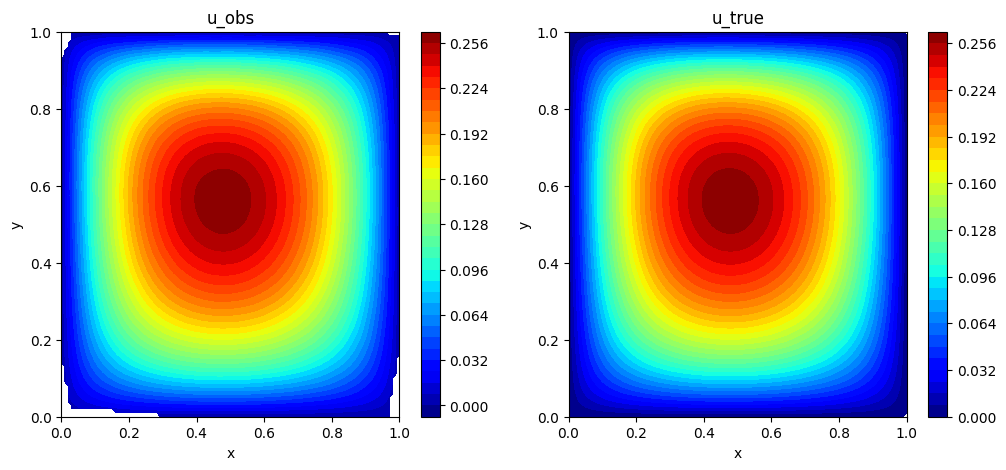

In [1]:
import numpy as np
import h5py
import torch
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
#
dataType = torch.float32
#
with h5py.File('inverse_observation.h5', 'r') as f:
    beta = torch.tensor(np.array(f['beta']).T, dtype=dataType)
    x_obs = torch.tensor(np.array(f['x_obs']).T, dtype=dataType) # observation position
    p_obs = torch.tensor(np.array(f['p_obs']).T, dtype=dataType) # observation of the pressure field
    X = torch.tensor(np.array(f['X']).T, dtype=dataType) # fine meshgrid
    Y = torch.tensor(np.array(f['Y']).T, dtype=dataType) # fine meshgrid
    p_true = torch.tensor(np.array(f['p']).T, dtype=dataType) # ground truth of the pressure field
    #
    x_test = torch.cat([X.reshape(-1,1), Y.reshape(-1,1)], dim=1)
    p_test = p_true.reshape(-1,1)
#
print('shape of x_obs:', x_obs.shape, 'shape of p_obs:', p_obs.shape)
print('shape of X:', X.shape, 'shape of Y:', Y.shape, 'shape of p:', p_true.shape)

####### Visualize the solution
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
#
z_plot = griddata((x_obs[:,0], x_obs[:,1]), np.ravel(p_obs.numpy()), (X, Y), method='cubic')
cntr = axs[0].contourf(X, Y, z_plot, levels=40, cmap='jet')
fig.colorbar(cntr, ax=axs.flat[:][0])
# axs[0].scatter(x_obs[:,0], x_obs[:,1], color='k')
axs[0].set_title('u_obs')
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')
#
cntr = axs[1].contourf(X, Y, p_true, levels=40, cmap='jet')
fig.colorbar(cntr, ax=axs.flat[:][1])
axs[1].set_title('u_true')
axs[1].set_xlabel('x')
axs[1].set_ylabel('y')
#
plt.show()

### (2.2) Solve the inverse problem with PINN

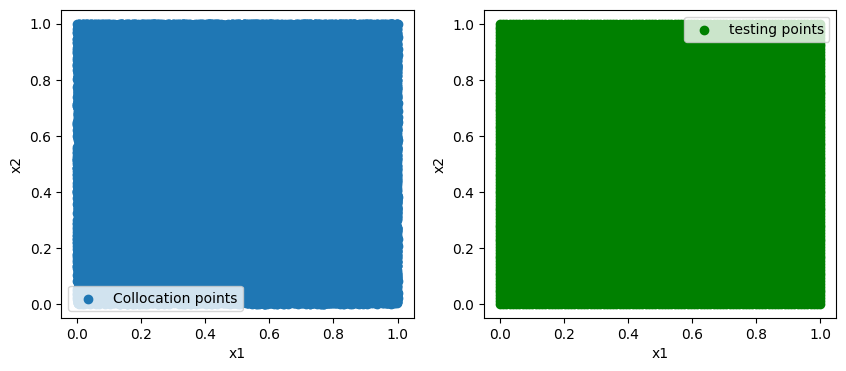

In [2]:
import numpy as np
import torch 
import torch.nn as nn
import matplotlib.pyplot as plt
device = 'cpu'
#
class MLP(nn.Module):

    def __init__(self, layers_list:list, dtype=None):
        super(MLP, self).__init__()
        # Network Sequential
        net = []
        self.hidden_in = layers_list[0]
        for hidden in layers_list[1:]:
            net.append(nn.Linear(self.hidden_in, hidden, dtype=dtype))
            self.hidden_in = hidden
        self.net = nn.Sequential(*net)

    def activation(self, x):
        '''Self-defined activation'''
        x = torch.tanh(x)
        x = torch.sin(torch.pi*x+torch.pi)
        return x
        
    def forward(self, x):
        # Input and hidden layers
        for net in self.net[:-1]:
            x = net(x)
            x = self.activation(x)
        # Output layer
        x = self.net[-1](x)

        return torch.nn.functional.silu(x)
####################################################
lb, ub = np.array([0., 0.]), np.array([1, 1.])
#
nc = 100000
dataType = torch.float32
np.random.seed(1234)
###### The truth solution: for generating the testing dataset, the initial condition, and the boundary condition
def k_true(x):
    '''The ground truth solution'''
    x1, x2 = x[...,0:1], x[...,1:2]
    #
    k = 2.1 + torch.sin(beta[0]*x1) + torch.cos(beta[1]*x2)
    
    return k
    
################################# The collocation points (x,t)
x_in = np.random.uniform(lb, ub, (nc,2))
x_in = torch.tensor(x_in, dtype=dataType)

# ################################# The testing dataset
k_test = k_true(x_test)

# ##################################
fig, axes = plt.subplots(1, 2, figsize=(10,4))
axes[0].scatter(x_in[...,0], x_in[...,1], label='Collocation points')
axes[0].set_xlabel('x1')
axes[0].set_ylabel('x2')
axes[0].legend()
#
axes[1].scatter(x_test[:,0], x_test[:,1], color='g', label='testing points')
axes[1].set_xlabel('x1')
axes[1].set_ylabel('x2')
axes[1].legend()
plt.show()

In [3]:
from torch.autograd import grad, Variable
#
torch.manual_seed(1234)
#
class Mollifier(object):
    '''For capturing the zero boundary condition'''

    def __init__(self, dim):
        self.dim = dim

    def apply(self, p, x):
        ''' '''
        for d in range(self.dim):
            p = p*torch.sin(torch.pi*x[...,d:d+1])
        return p

class LossClass(object):

    def __init__(self, p_model, k_model):
        self.device = device
        self.p_model = p_model 
        self.k_model = k_model
        self.getLoss = torch.nn.MSELoss()
        #
        self.mollifier = Mollifier(2)
    
    def loss_pde(self, x_in):
        '''loss term related to the PDE'''
        # return torch.tensor(0.)
        ################# The PDE loss
        x = Variable(x_in, requires_grad=True).to(self.device)
        #
        p = self.p_model(x)
        p = self.mollifier.apply(p, x)
        dp_dx = grad(inputs=x, outputs=p, grad_outputs=torch.ones_like(p), create_graph=True)[0]
        kx = self.k_model(x)
        # kx = 2.1 + torch.sin(beta[0]*x[:,0:1]) + torch.cos(beta[1]*x[:,1:2])
        #
        s = kx*dp_dx
        ds1_dx = grad(inputs=x, outputs=s[:,0:1], grad_outputs=torch.ones_like(s[:,0:1]), create_graph=True)[0]
        ds2_dx = grad(inputs=x, outputs=s[:,1:2], grad_outputs=torch.ones_like(s[:,1:2]), create_graph=True)[0]
        # The residuals
        residual = - (ds1_dx[:,0:1] + ds2_dx[:,1:2]) - 10 * torch.ones_like(kx)
        ###########################################
        loss = self.getLoss(residual, torch.zeros_like(residual))
        
        return loss

    def loss_data(self, x_obs, p_obs):
        '''loss term corresponds to the observation'''
        x = x_obs.to(self.device)
        p = self.p_model(x)
        p = self.mollifier.apply(p, x)
        #
        loss = self.getLoss(p, p_obs.to(self.device))
        
        return loss

    def get_error_p(self, x_test, p_test):
        '''Compute the L^2 relative error when the testing dataset is given'''
        x_test = x_test.to(self.device)
        p_test = p_test.to(self.device)
        p = self.p_model(x_test)
        p = self.mollifier.apply(p, x_test)
        
        return torch.sqrt(torch.sum((p-p_test)**2)/torch.sum(p_test**2))
        
    def get_error_k(self, x_test, k_test):
        '''Compute the L^2 relative error when the testing dataset is given'''
        x_test = x_test.to(self.device)
        k_test = k_test.to(self.device)
        k = self.k_model(x_test)
        
        return torch.sqrt(torch.sum((k-k_test)**2)/torch.sum(k_test**2))

########################## Create DataLoader for Mini-Batch Training
from torch.utils.data import Dataset, DataLoader
#
class MyDataset(Dataset):

    def __init__(self, x):
        self.x = x.reshape(-1, 2)

    def __getitem__(self, index):
        return self.x[index]

    def __len__(self):
        return self.x.shape[0]
        
dataloader = DataLoader(MyDataset(x_in), batch_size=1000, shuffle=True)

############ Training setups
from tqdm import trange
#
epochs = 100
lr = 1e-3
model_p = MLP([2, 40, 40, 40, 40, 1], dtype=torch.float32).to(device)
model_k = MLP([2, 40, 40, 40, 40, 1], dtype=torch.float32).to(device)
optimizer = torch.optim.Adam(params=list(model_p.parameters())+list(model_k.parameters()), lr=lr, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=np.int32(epochs/4), gamma=0.5)
#
############ The training process
w_pde = 2.
w_data = 200.
error_p_list, error_k_list = [],  []
for epoch in trange(epochs):
    for x_batch in dataloader:
        lossClass = LossClass(model_p, model_k)
        ############# Calculate losses
        loss_pde = lossClass.loss_pde(x_batch)
        loss_data = lossClass.loss_data(x_obs, p_obs)
        loss_train = w_pde * loss_pde + w_data * loss_data
        #
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()
    #
    with torch.no_grad():
        error_p = lossClass.get_error_p(x_test, p_test)
        error_p_list.append(error_p.item())
        error_k = lossClass.get_error_k(x_test, k_test)
        error_k_list.append(error_k.item())
    scheduler.step()  # Adjust learning rate
    #
    if (epoch+1)%25==0:
        print(f'Epoch:{epoch}, The loss is:{loss_train.item()}, lr: {scheduler.optimizer.param_groups[0]["lr"]}')
        print(error_p_list.pop(), error_k_list.pop())

 25%|██████████▌                               | 25/100 [01:17<03:44,  2.99s/it]

Epoch:24, The loss is:0.05697353556752205, lr: 0.0005
0.026899192482233047 0.07706984132528305


 50%|█████████████████████                     | 50/100 [02:31<02:27,  2.95s/it]

Epoch:49, The loss is:0.027090413495898247, lr: 0.00025
0.019579466432332993 0.05952002853155136


 75%|███████████████████████████████▌          | 75/100 [03:46<01:13,  2.93s/it]

Epoch:74, The loss is:0.0057966448366642, lr: 0.000125
0.014793423935770988 0.050129782408475876


100%|█████████████████████████████████████████| 100/100 [05:01<00:00,  3.02s/it]

Epoch:99, The loss is:0.027532782405614853, lr: 6.25e-05
0.011802950873970985 0.04604349285364151


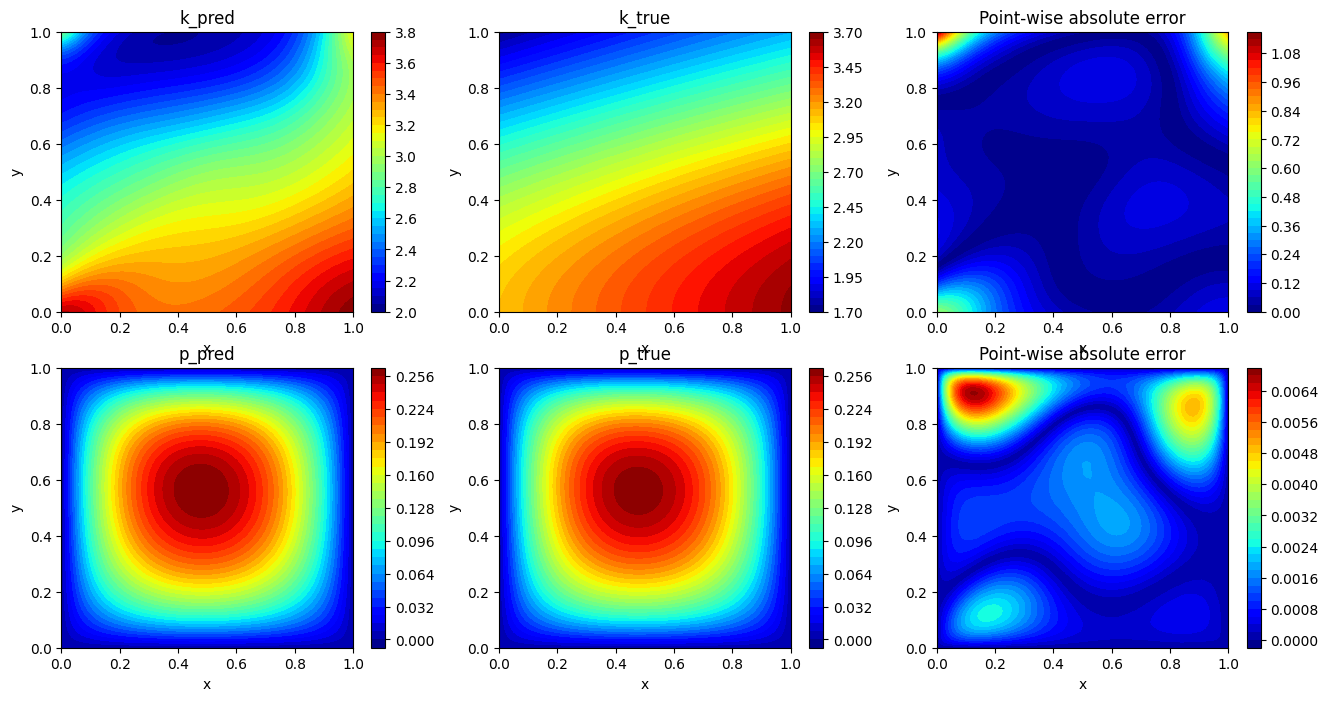

In [4]:
from scipy.interpolate import griddata

####### Make prediction with the trained model
x_query = x_test
# The prediction
p_query = model_p(x_query.to(device)).detach()
p_query = Mollifier(2).apply(p_query, x_query)
p_ref = p_test
k_query = model_k(x_query.to(device)).detach()
k_ref = k_true(x_query)

####### Visualize the solution
mesh = np.meshgrid(np.linspace(lb[0], ub[0], 100), np.linspace(lb[1], ub[1], 100))
x1_plot, x2_plot = mesh[0], mesh[1]
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(16, 8))
#
z_plot = griddata((x_query[:,0], x_query[:,1]), np.ravel(k_query), (x1_plot, x2_plot), method='cubic')
cntr = axs.flat[:][0].contourf(x1_plot, x2_plot, z_plot, levels=40, cmap='jet')
fig.colorbar(cntr, ax=axs.flat[:][0])
axs.flat[:][0].set_title('k_pred')
axs.flat[:][0].set_xlabel('x')
axs.flat[:][0].set_ylabel('y')
#
z_plot = griddata((x_query[:,0], x_query[:,1]), np.ravel(k_ref), (x1_plot, x2_plot), method='cubic')
cntr = axs.flat[:][1].contourf(x1_plot, x2_plot, z_plot, levels=40, cmap='jet')
fig.colorbar(cntr, ax=axs.flat[:][1])
axs.flat[:][1].set_title('k_true')
axs.flat[:][1].set_xlabel('x')
axs.flat[:][1].set_ylabel('y')
#
z_plot = griddata((x_query[:,0], x_query[:,1]), np.abs(np.ravel(k_ref)-np.ravel(k_query)), (x1_plot, x2_plot), method='cubic')
cntr = axs.flat[:][2].contourf(x1_plot, x2_plot, z_plot, levels=40, cmap='jet')
fig.colorbar(cntr, ax=axs.flat[:][2])
axs.flat[:][2].set_title('Point-wise absolute error')
axs.flat[:][2].set_xlabel('x')
axs.flat[:][2].set_ylabel('y')
#
z_plot = griddata((x_query[:,0], x_query[:,1]), np.ravel(p_query), (x1_plot, x2_plot), method='cubic')
cntr = axs.flat[:][3].contourf(x1_plot, x2_plot, z_plot, levels=40, cmap='jet')
fig.colorbar(cntr, ax=axs.flat[:][3])
axs.flat[:][3].set_title('p_pred')
axs.flat[:][3].set_xlabel('x')
axs.flat[:][3].set_ylabel('y')
#
z_plot = griddata((x_query[:,0], x_query[:,1]), np.ravel(p_test), (x1_plot, x2_plot), method='cubic')
cntr = axs.flat[:][4].contourf(x1_plot, x2_plot, z_plot, levels=40, cmap='jet')
fig.colorbar(cntr, ax=axs.flat[:][4])
axs.flat[:][4].set_title('p_true')
axs.flat[:][4].set_xlabel('x')
axs.flat[:][4].set_ylabel('y')
#
z_plot = griddata((x_query[:,0], x_query[:,1]), np.abs(np.ravel(p_test)-np.ravel(p_query)), (x1_plot, x2_plot), method='cubic')
cntr = axs.flat[:][5].contourf(x1_plot, x2_plot, z_plot, levels=40, cmap='jet')
fig.colorbar(cntr, ax=axs.flat[:][5])
axs.flat[:][5].set_title('Point-wise absolute error')
axs.flat[:][5].set_xlabel('x')
axs.flat[:][5].set_ylabel('y')
#
plt.show()

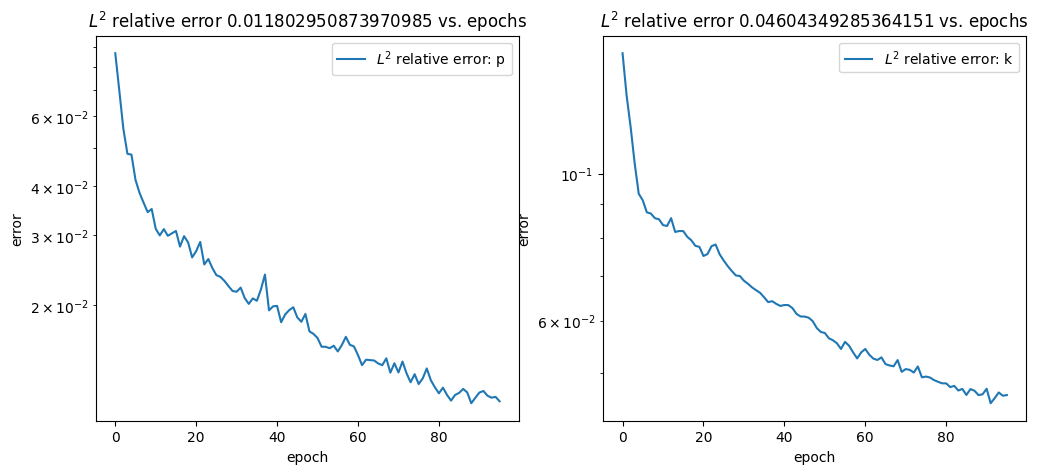

In [5]:
error_p = torch.sqrt(torch.sum((p_ref-p_query)**2)/torch.sum(p_ref**2))
error_k = torch.sqrt(torch.sum((k_ref-k_query)**2)/torch.sum(k_ref**2))
#
fig, axes = plt.subplots(1, 2, figsize=(12,5))
axes[0].semilogy(error_p_list, label='$L^2$ relative error: p')
axes[0].set_title(f'$L^2$ relative error {error_p} vs. epochs')
axes[0].set_xlabel('epoch')
axes[0].set_ylabel('error')
axes[0].legend()
#
axes[1].semilogy(error_k_list, label='$L^2$ relative error: k')
axes[1].set_title(f'$L^2$ relative error {error_k} vs. epochs')
axes[1].set_xlabel('epoch')
axes[1].set_ylabel('error')
axes[1].legend()
#
plt.show()

### <font color='red'>Question: Can DeepRitz method be used for solving inverse problem? why? </font>